# Universally robust identity gate with $X$ and $Y$ control

This file contains an example use case of the project. The setting here is that we have a qubit (quantum bit) with two control generators given by Pauli $X$ and Pauli $Y$ matrices. The goal is to find a control sequence implementing an identity gate that is robust all variations in the generator at first order.

The interface with the code is not well developed, but this example demonstrates roughly how I picture the code to be used; as expected use cases can vary heavily, the idea is to provide various tools to make it easy to construct control problems.

In [1]:
# first, add the project the path
import sys
sys.path.append('../')

# functions from outside the project that we'll need
from math import pi
from numpy import zeros,real, identity
from numpy.random import rand

# Define the control system

First define the control system. It has 0 drift generators, and two control generators given by $-i\pi X$ and $-i\pi Y$.

Afterwards, define the decoupling system, which is derived from the base system, and computes first order robustness terms for $-i \pi X$, $-i \pi Y$, and $-i \pi Z$. The universal property of the sequence comes from these matrices being a basis for traceless $2 \times 2$ Hermitian matrices.

In [2]:
import hamiltonians as h # a file containing Pauli matrices
from control_system import control_system # the control_system object

drift_generator = zeros((2,2)) # zero generator
control_generators = [-1j*pi*h.pauliX(),-1j*pi*h.pauliY()] # pauli X control generator
xy_sys = control_system(drift_generator, control_generators) # create control_system instance

# Define the derived decoupling system
xy_univ_dec = xy_sys.decoupling_system([-1j*pi*h.pauliX(), -1j*pi*h.pauliY(),-1j*pi*h.pauliZ()])

# Set parameters of search
The parameters we require:
1. Number of time steps, $N$
2. Length of each time step, $dt$
3. Target gate $U_{target}$
4. Bounds on the absolute value of the control amplitudes and tolerance
5. Bounds on the rate of change of the control amplitudes and tolerance

Note that, aside from number of time steps, the parameters set here are essentially arbitrary, and in practice would be set by the physical system of interest. The number of time steps here was arrived at by running the search on various values, until a value of $N$ was found for which:
1. The objective function can be optimized to the best possible value.
2. Decreasing $N$ by $1$ results in no (currently tested) searches achieving the best possible  objective value.
Hence, the above two points suggest that the current value of $N$ is roughly the shortest possible value for which a control sequence with the desired properties exists.

In [3]:
N=76 # number time steps
dt = 0.05 # time step length

# bounds on power and tolerance.
# Note the first entry in the upper/lower bounds is for the first control amplitude,
# and the second is for the second. The same tolerance is used for both.
power_ub = [1,1] # upper bounds
power_lb = [-1,-1] # lower bounds
power_tol = 0.0005 # tolerance

# bounds on rate of change
change_b = [0.05,0.05] # rate of change bounds for each amplitude
change_tol = 0.0005 # tolerance


# target gate
Utarget = identity(2)

# set a variable storing the shape of a control sequence array
# ctrl_shape = (# time steps, # control amplitudes)
ctrl_shape = (N, 2)

# Define the objective

Next, define the objective. Components of the objective are:
1. Optimizing the final gate to be identity.
2. Optimizing terms in the derived decoupling system quantifying robustness to $X,Y,Z$ be $0$
3. Constraints on amplitude of the control sequence implemented as penalties.

Note that objectives are currently assumed to take in a 2d array of shape ctrl_shape, and output a tuple (val, vald), where val is the value of the objective at the input, and vald is the jacobian of the objective at the input.

In [4]:
# import functions from the package to help
from evolve_system import evolve_system # computes system propagator and derivatives
from objective_functions import grape_objective, zero_block_objective # for gate and decoupling optimization
from constraint_functions import mono_objective as penalty # for constraints as penalties

# Construct an objective using the ingredients provided by the project
def obj(x):
    prop = evolve_system(xy_univ_dec, x, dt, deriv = 1) #evolve the system

    Ufinal = prop[0][0:2,0:2] # extract final unitary
    Uderiv = prop[1][:,0:2,0:2] # extract jacobian of final unitary

    # final gate objective
    g,gp = grape_objective(Utarget, (Ufinal, Uderiv), deriv = 1)
    
    # first order robustness to variations in X,Y,Z
    decx,decxd= zero_block_objective(prop, 2, 0,1, deriv = 1)
    decy,decyd= zero_block_objective(prop, 2, 1,2, deriv = 1)
    decz,deczd= zero_block_objective(prop, 2, 2,3, deriv = 1)
    dec = decx+ decy+decz # total robustness value
    decd = decxd + decyd + deczd # total robustness jacobian

    # constraints as penalties
    shape,shaped = penalty(x, power_lb, power_ub, power_tol, change_b, change_tol, deriv = 1)

    # return a weighted combination (to be used in minimization)
    return real(-g + dec + shape/100), real(-gp + decd + shaped/100)

# Run the optimization

Currently, the optimizer used is the implementation of BFGS available in SciPy.

Note:
1. Best possible value of this objective is $-4$.
2. With current parameters, often finds a solution within $10^{-10}$ of $-4$, but as the number of time steps seems to be at the edge of what is possible, it will not always find a good solution, and will need to be run again. In my experience, the runs that find a good solution usually get pretty close to -4 within 1000 function evalutions, though may still take close to 3000 to finish. Runs that don't get close to the optimal value within 1000-2000 evaluations seem to never converge to the optimal value, or at least take so long that it is worth restarting with a new initial guess.

In [6]:
# import the optimizer
from pulse_finders import find_pulse_bfgs

update_rate = 200 # rate of printed updates
initial_guess = rand(*ctrl_shape)*change_b # random initial guess

results = find_pulse_bfgs(obj, ctrl_shape, initial_guess, update_rate) # run optimization

Optimizing pulse...
Value at evaluation 200: 260.2693076848356
Value at evaluation 400: 20.983403451578205
Value at evaluation 600: 0.9622689240804101
Value at evaluation 800: -3.8288612983632513
Value at evaluation 1000: -3.978038437105106
Value at evaluation 1200: -3.9916552987823835
Value at evaluation 1400: -3.9980393418139113
Value at evaluation 1600: -3.999394990576986
Value at evaluation 1800: -3.9997432815053617
Value at evaluation 2000: -3.9999181736203666
Value at evaluation 2200: -3.999997111890613
Value at evaluation 2400: -3.9999999963553097
Optimization terminated successfully.
         Current function value: -4.000000
         Iterations: 1873
         Function evaluations: 2435
         Gradient evaluations: 2435
Total time taken: 83.15790605545044


In [8]:
amps = results.x # get the control sequence from the results object
4+results.fun # how close the value achieved is to the optimal

8.081313396246514e-11

# Plotting
Now that a sequence numerically satisfying the desired criteria has been found, we can examine its properties. Currently, the plotting features in this project are rudimentary, but some simple plots demonstrate that the optimization is functioning as desired.

## Plot the control sequence itself
First, just plot the amplitudes as a function of time.

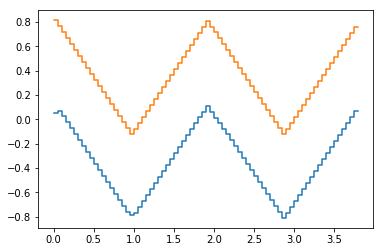

In [9]:
import control_plotting as cplot # import the plotting file

cplot.step_plot(amps, dt)

Note that each search will output a slightly different shape, but the searches that converge to a value close to $-4$ all seem to have roughly the same shape. This shape is somewhat like an XY4 sequence.

The smoothness constraints ensure that the amplitude can't change much between time steps. Typically, when performing these searches:
1. If, given all of the other constraints, the number of time steps is only just long enough for the objective to achieve the best possible value, the control sequence will tend to have nice structure.
2. If the number of time steps is well beyond the minimum time required to achieve the objective function's optimal value, then it will tend to not have much structure. 


## Robustness plot 

Next, we plot the fidelity as a function of $\epsilon$ with respect to variations of the generator of the form $\epsilon(-i \pi X)$,$\epsilon(-i \pi Y)$, and $\epsilon(-i \pi Z)$

### Robustness in $X$:

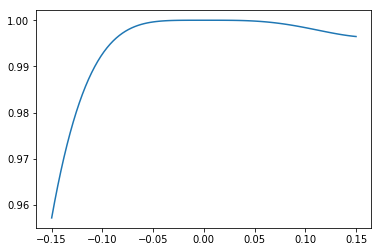

In [10]:
# set the range of values of epsilon to check
from numpy import linspace

bound = 0.15
steps = 100
eps = linspace(-bound, bound, steps)
x_var = -1j*pi*h.pauliX()

cplot.target_robustness_1d(xy_sys, amps,dt, Utarget, x_var, eps)

### Robustness in $Y$

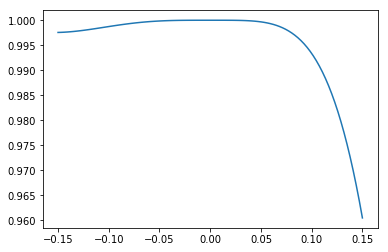

In [11]:
y_var = -1j*pi*h.pauliY()
cplot.target_robustness_1d(xy_sys, amps,dt, Utarget, y_var, eps)

### Robustness in $Z$

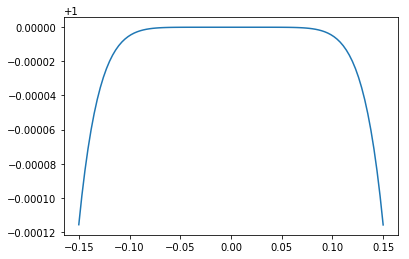

In [12]:
z_var = -1j*pi*h.pauliZ()
cplot.target_robustness_1d(xy_sys, amps,dt, Utarget, z_var, eps)

### Robustness in some random direction

The pulse is supposed to be universally robust, but so far we have plotted robustness for variations in the directions we had specified in the search. We can choose a random direction and plot the robustness for that.

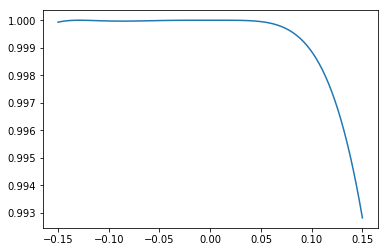

Direction: x=0.6952543498499123, y=0.2848305008104424, z=0.6599189153394894


In [13]:
# get a normalized vector
from numpy.linalg import norm
vec = rand(3)
vec = vec/norm(vec)

# variation in that direction
r_var = -1j*pi*(vec[0]*h.pauliX() + vec[1]*h.pauliY()+vec[2]*h.pauliZ())

cplot.target_robustness_1d(xy_sys, amps,dt, Utarget, r_var, eps)
print('Direction: x=' + str(vec[0]) + ', y=' + str(vec[1]) + ', z=' + str(vec[2]))

### Robustness comments

As desired, the robustness plots are all flat at $\epsilon = 0$. In terms of how wide the flat part of the plot is, the sequence appears to be much more robust against variations in the $Z$ direction than any other direction, which is perhaps to be expected as the controls lie in the $xy$ plane. 

The fidelity as a function of variations in a random direction is, as designed, also flat at $\epsilon = 0$, though how wide the plateau is of course depends on the direction. 